In [1]:
%cd ..

/home/fedora/Jupyter/river-profiles


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import schemes
from tqdm.notebook import tqdm

import imageio as io
from PIL import Image

# Check schemes for noncontinuous functions
In our case the function $\nu$ from the equation
$$
\cfrac{\partial\lambda}{\partial\tau} + \cfrac{\partial\lambda}{\partial\tau} = \nu(\tau, \chi)
$$
looks like
$$
\nu(\tau, \chi) = 
\nu(\tau) = 
\begin{cases}
\nu_0,\; \tau < \tau_0 \\
\nu_i,\; \tau_{i-1} < \tau < \tau_i, \; i = 1, ..., k-1\\
\nu_k,\; \tau > \tau_k
\end{cases}
$$

So this is not continuous. Let's check, how schemes will work with functions like this.

In [3]:
def lengths_check(borders, values, raise_error=True):
    # Returns True, if lengths are correct: borders array should contain 1 element less, than values array
    # If this is not correct, it will raise error if raise_error or return Flase in other case.
    r = len(values) - len(borders) == 1
    if raise_error and not r:
        msg = f'Wrong arrays lengths: borders array should contain 1 element less, than values array. But their length are {len(borders)} and {len(values)}.'
        raise ValueError(msg)
        
    borders = np.array(borders)
    if (borders[1:] - borders[:-1] <= 0).any():
        warnings.warn("The borders array is not strictly increasing")
    return r

In [4]:
def stair_function(x, borders=[], values=[0]):
    """
    Parameters:
    -----------
    x : float or float array
        The argument of the function
    
    borders : list of floats len N
        The points, when the function changes the value
    
    values: list of floats len N+1
        values[0] corresponds to the function value before borders[0]
        values[i] corresponds to the function value between borders[i-1] and borders[i]
        
    Returns:
    --------
    r : float or float array shape x.shape
    """
    lengths_check(borders, values, raise_error=True)
    x = np.array(x)
    if x.shape == ():
        r = values[0]*np.ones(1)
    else:
        r = values[0]*np.ones(x.shape)
    for i in range(len(borders)):
        r[x >= borders[i]] = values[i+1]
    if x.shape == ():
        return r[0]
    return r

Let's construct a test $\nu(\tau, \chi)$ as product of two similar stair functions over $\tau$ and over $\chi$:
$$
\nu(\tau, \chi) = s(\tau)s(\chi)
$$
where
$$
s(t) = 
\begin{cases}
\cfrac{1}{2}, \; t < 1 \\
2, \; 1 \le t < 2 \\
1, \; 2 \le t
\end{cases}
$$

So for $\tau\in[0, 3]$, $\chi\in[0, 3]$ the values of $\nu(\tau, chi)$ will be:

| | $\chi\in[0, 1)$ |  $\chi\in[1, 2)$ |  $\chi\in[2, 3]$ | 
| -- | -- | -- | -- |
| $\tau\in[0, 1)$ | $\cfrac{1}{4}$ | $1$ | $\cfrac{1}{2}$ |
| $\tau\in[1, 2)$ | $1$            | $4$ | $2$            |
| $\tau\in[2, 3]$ | $\cfrac{1}{2}$ | $2$ | $1$            |

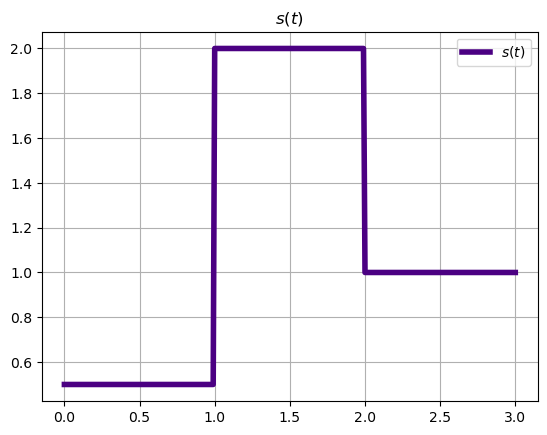

In [5]:
s = lambda t: stair_function(t, borders=[1, 2], values=[0.5, 2, 1])

t = np.linspace(0, 3, 301)

plt.title('$s(t)$')
plt.plot(t, s(t), linewidth=4, color='indigo', label='$s(t)$')
plt.legend()
plt.grid(True)
plt.show()

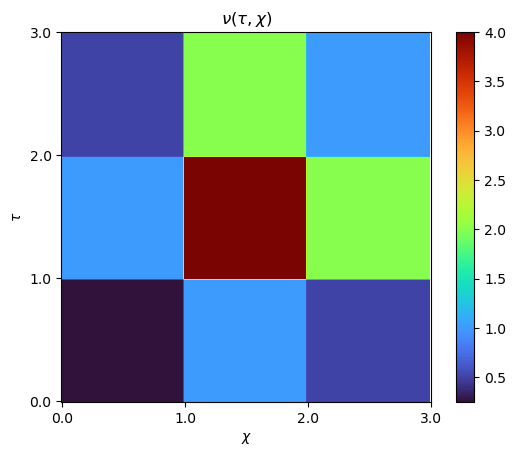

In [6]:
nu = lambda tau, chi: s(tau)*s(chi)

n = 301
tau_space = np.ones([n, n])*np.linspace(0, 3, n).reshape([1, n])
chi_space = np.ones([n, n])*np.linspace(0, 3, n).reshape([n, 1])


plt.title(r'$\nu(\tau, \chi)$')
im = plt.imshow(nu(tau_space, chi_space), origin='lower', cmap='turbo')
plt.colorbar(im)
plt.xticks(np.linspace(0, n, 4), np.linspace(0, n, 4)/n*3)
plt.yticks(np.linspace(0, n, 4), np.linspace(0, n, 4)/n*3)
plt.xlabel(r'$\chi$')
plt.ylabel(r'$\tau$')

plt.show()

And let's set the border value as $\lambda(\tau, 0) = 0$, and the initial value as the line:
$$
\lambda(0, \chi) = \phi(\chi) = \nu(0, 0)^{1/n}\chi
$$

In [7]:
approxes = [schemes.approx1, schemes.approx1nonlinear, schemes.approx2nonlinear]

ns = [1, 2, 0.5]

dtau = 0.05
ntau = 61
dchi = 0.05
nchi = 61
assert dtau*(ntau - 1) == 3
assert dchi*(nchi - 1) == 3

sols = []

with tqdm(total=len(approxes)*len(ns)) as casesbar:
    with tqdm(total=(ntau - 1)*(nchi - 1)) as schemebar:
        for n in ns:
            for approx in approxes:
                schemebar.reset()
                initial = lambda chi: chi*nu(0, 0)**(1/n)
                border = lambda tau: 0*tau
                if approx == schemes.approx1:
                    sol, tau_space, chi_space = approx(nu, initial=initial, border=border, 
                                                       dtau=dtau, dchi=dchi, ntau=ntau, nchi=nchi)
                    schemebar.update((ntau - 1)*(nchi - 1))
                else:
                    sol, tau_space, chi_space = approx(nu, initial=initial, border=border, 
                                                       dtau=dtau, dchi=dchi, ntau=ntau, nchi=nchi, 
                                                       bar=schemebar)
                sols.append({'scheme' : approx.__name__, 'n': n, 'sol': sol.copy()})
                casesbar.update(1)

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/3600 [00:00<?, ?it/s]

/usr/lib64/python3.11/site-packages/scipy/optimize/_minpack_py.py:178: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


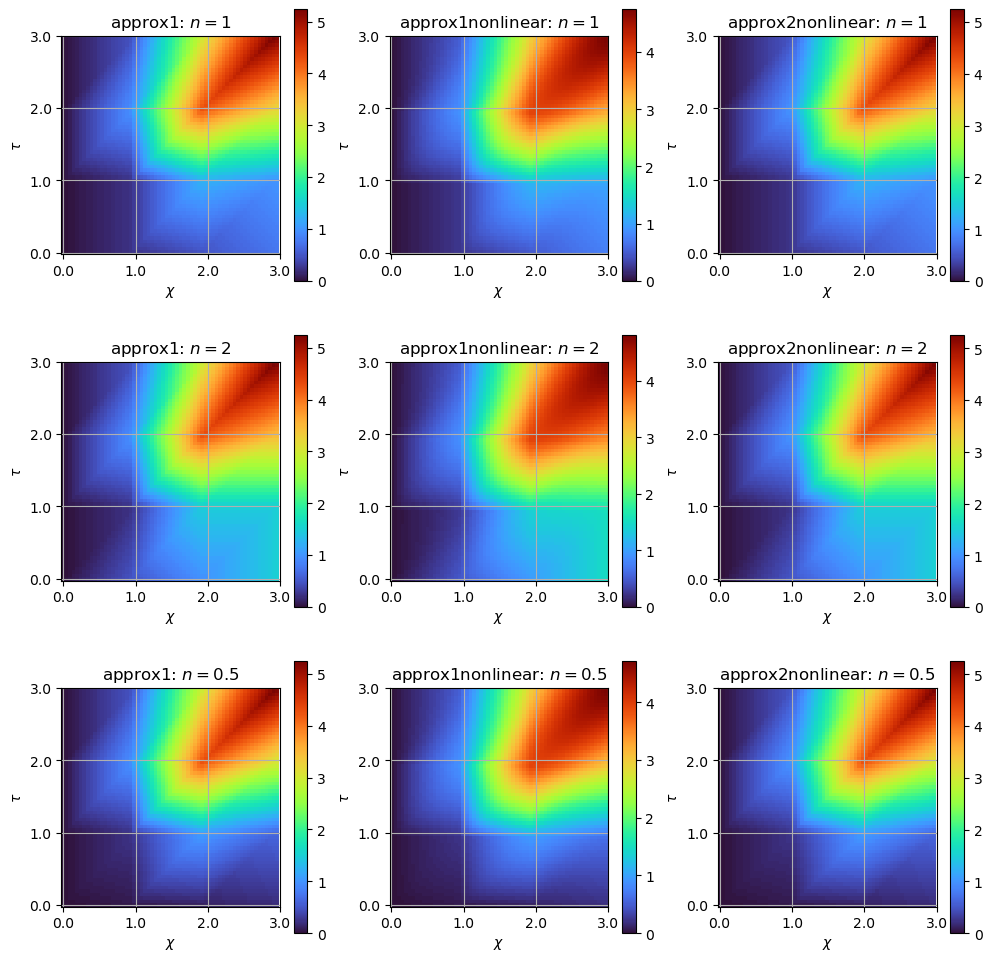

In [8]:
fig, axs = plt.subplots(len(approxes), len(ns))

fig.set_figheight(12)
fig.set_figwidth(12)

for i, sol in enumerate(sols):
    irow, icol = i//len(ns), i%len(ns)
    axs[irow, icol].set_title(f"{sol['scheme']}: $n = {sol['n']}$")
    im = axs[irow, icol].imshow(sol['sol'], origin='lower', cmap='turbo')
    plt.colorbar(im)
    
    axs[irow, icol].set_xticks(np.linspace(0, ntau, 4), np.linspace(0, ntau, 4)/ntau*3)
    axs[irow, icol].set_yticks(np.linspace(0, nchi, 4), np.linspace(0, nchi, 4)/nchi*3)
    axs[irow, icol].set_xlabel(r'$\chi$')
    axs[irow, icol].set_ylabel(r'$\tau$')
    axs[irow, icol].grid(True)

In [9]:
df = pd.DataFrame(sols)
df

,scheme,n,sol
0,approx1,1.0,"[[0.0, 0.0125, 0.025, 0.037500000000000006, 0...."
1,approx1nonlinear,1.0,"[[0.0, 0.0125, 0.025, 0.037500000000000006, 0...."
2,approx2nonlinear,1.0,"[[0.0, 0.0125, 0.025, 0.037500000000000006, 0...."
3,approx1,2.0,"[[0.0, 0.025, 0.05, 0.07500000000000001, 0.1, ..."
4,approx1nonlinear,2.0,"[[0.0, 0.025, 0.05, 0.07500000000000001, 0.1, ..."
5,approx2nonlinear,2.0,"[[0.0, 0.025, 0.05, 0.07500000000000001, 0.1, ..."
6,approx1,0.5,"[[0.0, 0.003125, 0.00625, 0.009375000000000001..."
7,approx1nonlinear,0.5,"[[0.0, 0.003125, 0.00625, 0.009375000000000001..."
8,approx2nonlinear,0.5,"[[0.0, 0.003125, 0.00625, 0.009375000000000001..."


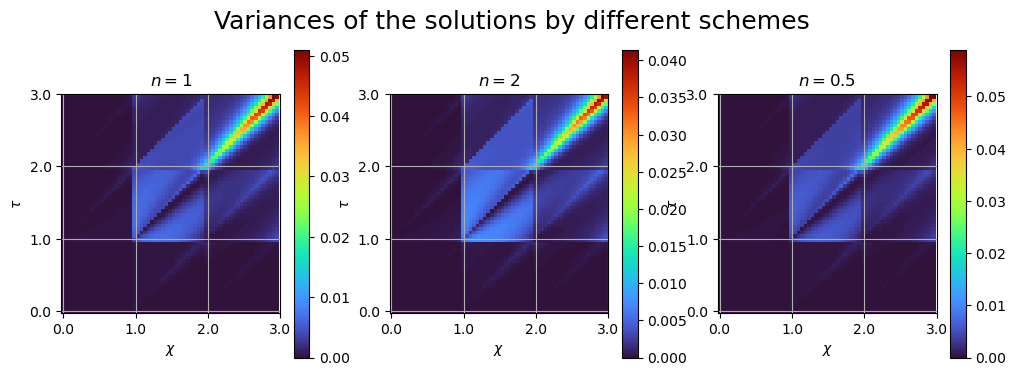

In [10]:
fig, axs = plt.subplots(1, len(ns))

fig.set_figheight(4)
fig.set_figwidth(12)

fig.suptitle('Variances of the solutions by different schemes', fontsize=18)

for i, n in enumerate(ns):
    dfi = df[df['n'] == n]
    var = np.array(list(dfi['sol'].values)).var(axis=0)
    
    axs[i].set_title(f'$n = {n}$')
    im = axs[i].imshow(var, origin='lower', cmap='turbo')
    plt.colorbar(im)
    
    axs[i].set_xticks(np.linspace(0, ntau, 4), np.linspace(0, ntau, 4)/ntau*3)
    axs[i].set_yticks(np.linspace(0, nchi, 4), np.linspace(0, nchi, 4)/nchi*3)
    axs[i].set_xlabel(r'$\chi$')
    axs[i].set_ylabel(r'$\tau$')
    axs[i].grid(True)
plt.show()

In [11]:
images = []

maxnu = nu(np.arange(9)%3, np.arange(9)//3).max()
maxlam = np.array(list(df['sol'].values)).max()
maxval = max(maxnu, maxlam)


with tqdm(total=ntau) as pbar:
    for itau in range(ntau):
        tau_val = itau*dtau
        fig, axs = plt.subplots(len(ns))
        fig.set_figwidth(8)
        fig.set_figheight(12)
        fig.suptitle(f'$\\tau = {tau_val:.2f}$', fontsize=18)
        for ni, n in enumerate(ns):
            axs[ni].set_title(f'$n = {n}$')
            
            axs[ni].plot(chi_space, nu(tau_val, chi_space), label=r'$\nu(\tau, \chi)$',
                         color='orchid', linewidth=6, alpha=0.5)
            for sol in sols:
                if sol['n'] == n:
                    axs[ni].plot(chi_space, sol['sol'][itau], label=f"$\\lambda$ by {sol['scheme']}", linewidth=3)
            axs[ni].grid(True)
            axs[ni].legend(loc='upper left')
            axs[ni].set_xlabel(r'$\chi$')
            axs[ni].set_yticks(np.linspace(0, maxval, 8))
            #axs[ni].set_ylabel(r'$\lambda$')
            
        fig.canvas.draw()
        images.append(Image.frombytes('RGB', fig.canvas.get_width_height(),fig.canvas.tostring_rgb()))
        #plt.savefig(f'pics/schemes/schemes_noncontinuos-{itau}.png')
        plt.close('all')
        del fig
        
        pbar.update()

filename = 'gifs/schemes_noncontinuos.gif'
io.mimsave(filename, images, fps=12, loop=0)
print(f'generated and saved to path {filename}')

  0%|          | 0/61 [00:00<?, ?it/s]

generated and saved to path gifs/schemes_noncontinuos.gif


In [12]:
images = []

maxnu = nu(np.arange(3), 0.5).max()
maxlam = np.array(list(df['sol'].values))[:, chi_space < 1].max()
maxval = max(maxnu, maxlam)


with tqdm(total=ntau) as pbar:
    for itau in range(ntau):
        tau_val = itau*dtau
        fig, axs = plt.subplots(len(ns))
        fig.set_figwidth(8)
        fig.set_figheight(12)
        fig.suptitle(f'$\\tau = {tau_val:.2f}$', fontsize=18)
        for ni, n in enumerate(ns):
            axs[ni].set_title(f'$n = {n}$')
            
            axs[ni].plot(chi_space[chi_space < 1], nu(tau_val, chi_space)[chi_space < 1], 
                         label=r'$\nu(\tau, \chi)$',
                         color='orchid', linewidth=6, alpha=0.5)
            for sol in sols:
                if sol['n'] == n:
                    axs[ni].plot(chi_space[chi_space < 1], sol['sol'][itau, chi_space < 1], 
                                 label=f"$\\lambda$ by {sol['scheme']}", linewidth=3)
            axs[ni].grid(True)
            axs[ni].legend(loc='upper left')
            axs[ni].set_xlabel(r'$\chi$')
            axs[ni].set_yticks(np.linspace(0, maxval, 8))
            #axs[ni].set_ylabel(r'$\lambda$')
            
        fig.canvas.draw()
        images.append(Image.frombytes('RGB', fig.canvas.get_width_height(),fig.canvas.tostring_rgb()))
        #plt.savefig(f'pics/schemes/schemes_noncontinuos-chi0-{itau}.png')
        plt.close('all')
        del fig
        
        pbar.update()

filename = 'gifs/schemes_noncontinuos-chi0.gif'
io.mimsave(filename, images, fps=12, loop=0)
print(f'generated and saved to path {filename}')

  0%|          | 0/61 [00:00<?, ?it/s]

generated and saved to path gifs/schemes_noncontinuos-chi0.gif


__Conclusion:__ These approximations gives the similar result.